In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -R /content/drive/MyDrive/Colab\ Notebooks/AI_HW1 /content

In [4]:
import os
import warnings
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")

In [52]:
threshold_db = -20
sample_rate = 128
fq_range = 22050
size_per_class = 10

batch_size = 8
epochs = 3

max_audio_length = 0
file_names = []
class_labels = []

In [6]:
def import_func(path, update_max, max_audio_length):
  file_n = []
  class_l = []
  for root, dirs, files in os.walk(path):
    # root = folder name(class), files = array of file names (dir is for the directory(folder) inside the folder)
    for file in files:
        file_path = os.path.join(root, file)
        file_n.append(file_path)
        class_l.append(os.path.basename(root))

        # Find the audio length after trim quiet
        # (1) Load
        signal, sr = librosa.load(file_path, sr=None)
        # (2) Trim the part below thres amplitude
        threshold_amplitude = librosa.db_to_amplitude(threshold_db)
        audio_trimmed, _ = librosa.effects.trim(signal, top_db=threshold_db)

        # Update max length
        if(update_max != 0):
          max_audio_length = max(max_audio_length, len(signal))
        
        # Break when enough data
        if (len(file_n) % size_per_class == 0):
            break
        
  return file_n, class_l, max_audio_length

In [53]:
# Set the path
audio_path = '/content/AI_HW1/guitar_chord'

file_names, class_labels, max_audio_length = import_func(audio_path, 1, max_audio_length)

In [9]:
# Preprocess audio funtion
def preprocess_audio(audio_path, max_audio_length):
    # Load
    signal, sr = librosa.load(audio_path, sr=None)

    # Trim the audio file
    #signal, _ = librosa.effects.trim(signal, top_db=threshold_db)
    
    # Pad to the max length
    if len(signal) < max_audio_length:
        signal = np.pad(signal, (0, max_audio_length - len(signal)), 'constant')
    else:
        signal = signal[:max_audio_length]
    
    # Sample the audio file to ? Hz
    signal = librosa.resample(signal, sr, fq_range)
    
    # Compute the Mel spectrogram, accord to ? Hz, and by ? steps
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=fq_range, n_mels=sample_rate)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        
    # Normalize the Mel spectrogram to have zero mean and unit variance
    norm_log_mel_spec = (log_mel_spec - np.mean(log_mel_spec)) / np.std(log_mel_spec)
    
    return norm_log_mel_spec

In [54]:
# Preprocess audio
preprocessed_data = []
for file_name in file_names:
    preprocessed_audio = preprocess_audio(file_name, max_audio_length)
    preprocessed_data.append(preprocessed_audio)


[3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5]


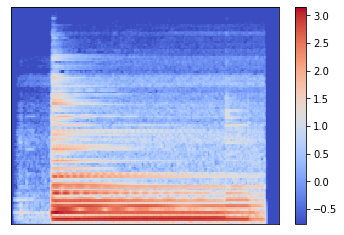

In [55]:
# Display Mel spectrogram for the first data
plt.figure()
librosa.display.specshow(preprocessed_data[0])
plt.colorbar()

# Convert the preprocessed data to a numpy array
num_preprocessed_data = np.array(preprocessed_data)

# Convert the class labels (C, G, A) to integers
class_to_int = {class_label: i for i, class_label in enumerate(np.unique(class_labels))}
y = np.array([class_to_int[class_label] for class_label in class_labels])

print(y)
# Get the first index of each class label in class_labels
class_indices = [np.where(y == label)[0][0] for label in np.unique(y)]

# Create a mask to select the corresponding preprocessed data
mask = np.zeros(num_preprocessed_data.shape[0], dtype=bool)
mask[class_indices] = True
selected_data = num_preprocessed_data[mask]

for selected in selected_data:
  librosa.display.specshow(selected)

# Reshape the data to add a "channels" dimension
num_preprocessed_data = np.expand_dims(num_preprocessed_data, axis=-1)


1/1 [==============================] - 0s 20ms/step
Validation set accuracy: 1.0
[[2. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 2.]]


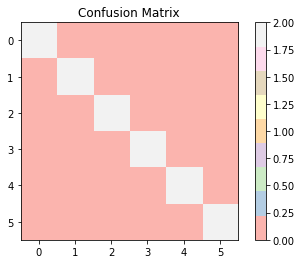

In [57]:
# 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=31)

accuracy_scores = []
cms = []

# Train using cross-validation
for train_index, val_index in skf.split(num_preprocessed_data, class_labels):
    # Split data
    X_train, X_val = num_preprocessed_data[train_index], num_preprocessed_data[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # model 
    # Create model
    model = Sequential()

    # Add layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    # Train
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate on val
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    accuracy = accuracy_score(y_val, y_val_pred)
    # store accuracy
    accuracy_scores.append(accuracy)
    
    cm = confusion_matrix(y_val, y_val_pred)
    # store cm
    cms.append(cm)


# Average accuracy
print("Validation set accuracy:", np.mean(accuracy_scores))

# Average confusion matrix
cm = np.mean(cms, axis=0)
print(cm)
cmap = plt.get_cmap('Pastel1')
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

Validation set accuracy: 0.9791666666666666
[[8.  0.  0.  0.  0.  0. ]
 [0.  8.  0.  0.  0.  0. ]
 [0.  0.  7.6 0.4 0.  0. ]
 [0.  0.  0.4 7.6 0.  0. ]
 [0.  0.  0.  0.  7.8 0.2]
 [0.  0.  0.  0.  0.  8. ]]


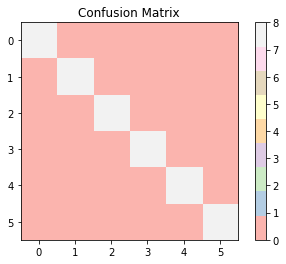

In [41]:
# 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=31)

# Model
rfc = RandomForestClassifier(n_estimators=50, random_state=42)

accuracy_scores = []
cms = []

# Train using cross-validation
for train_index, val_index in skf.split(num_preprocessed_data, class_labels):
    # Split data
    X_train, X_val = num_preprocessed_data[train_index], num_preprocessed_data[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Reshape the data (2D -> 1D) for Random Forest (rf take 1D input data)
    X_train_rf = X_train.reshape(X_train.shape[0], -1)
    X_val_rf = X_val.reshape(X_val.shape[0], -1)

    # Train
    rfc.fit(X_train_rf, y_train)

    # Make predictions on val
    y_val_pred_rf = rfc.predict(X_val_rf)
    accuracy = accuracy_score(y_val, y_val_pred_rf)
    # store accuracy
    accuracy_scores.append(accuracy)

    cm = confusion_matrix(y_val, y_val_pred_rf)
    # store cm
    cms.append(cm)

# Average accuracy
print("Validation set accuracy:", np.mean(accuracy_scores))

# Average confusion matrix
cm = np.mean(cms, axis=0)
print(cm)
cmap = plt.get_cmap('Pastel1')
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

Validation set accuracy: 0.8041666666666666
[[5.6 2.4 0.  0.  0.  0. ]
 [1.6 6.4 0.  0.  0.  0. ]
 [0.  0.  7.  0.8 0.2 0. ]
 [0.  0.  1.8 5.6 0.2 0.4]
 [0.  0.  0.2 0.2 6.8 0.8]
 [0.  0.  0.  0.  0.8 7.2]]


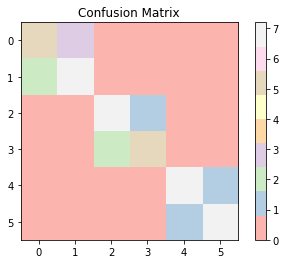

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=31)

# Model
knn = KNeighborsClassifier(n_neighbors=10)

accuracy_scores = []
cms = []

# Train using cross-validation
for train_index, val_index in skf.split(num_preprocessed_data, class_labels):
    # Split data
    X_train, X_val = num_preprocessed_data[train_index], num_preprocessed_data[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Reshape the input data to 2D
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    X_val_2d = X_val.reshape(X_val.shape[0], -1)

    # Train
    knn.fit(X_train_2d, y_train)

    # Make predictions on val
    y_val_pred = knn.predict(X_val_2d)
    accuracy = accuracy_score(y_val, y_val_pred)
    # store accuracy
    accuracy_scores.append(accuracy)

    cm = confusion_matrix(y_val, y_val_pred)
    # store cm
    cms.append(cm)

# Average accuracy
print("Validation set accuracy:", np.mean(accuracy_scores))

# Average confusion matrix
cm = np.mean(cms, axis=0)
print(cm)
cmap = plt.get_cmap('Pastel1')
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()
